# Random forest

Construct a random forest model and set up cross-validated grid-search to exhuastively search for the best model parameters.

## Imports

In [9]:
# Imports
import sys

# Adds the project root and utils directory to the PYTHONPATH
sys.path.append("..")
sys.path.append("../utils")  

# Imports everything from common_imports.py and config
from common_imports import *  
from config import *

# Load train / test datasets
# Train sets
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)

# Test sets
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)

## Modelling

In [10]:
# Instantiate model
rf = RandomForestClassifier(random_state=42)

# Hyperparameters
cv_params = {'max_depth' : [1, 3, 5, 10, None],
             'max_features' : [0.5, 1.0],
             'max_samples' : [0.5, 0.7, 1.0],
             'min_samples_leaf' : [1, 2, 5],
             'min_samples_split' : [2, 3, 5],
             'n_estimators' : [300, 500]}

# Scoring
scoring = {'accuracy' : 'accuracy',
           'precision' : 'precision',
           'f1' : 'f1',
           'recall' : 'recall',
           'roc_auc' : 'roc_auc'}

# Instantiate GridSearch
rf_cv1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='roc_auc', n_jobs=-1)

In [11]:
# %%time

# # Fit the model on test data
# rf_cv1.fit(X_train, y_train)

In [12]:
# Path to the model
path = '../model/'

# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

Identify the best AUC score achieved by the random forest model on the training set.

In [13]:
# Check best AUC score on CV
rf1.best_score_

0.9822332189983131

Identify the optimal values for the parameters of the random forest model.

In [14]:
# Check best params
rf1.best_params_

{'max_depth': None,
 'max_features': 0.5,
 'max_samples': 1.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 300}

In [16]:
# Load `model_results` DataFrame
results = pd.read_csv(model_results_path)

# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')

# Update `results` DataFrame
results = pd.concat([results, rf1_cv_results], axis=0)

# Sort 'results' by F1-score
results = results.sort_values(by='F1', ascending=False).reset_index(drop=True)

# Display `results` Dataframe
results

,model,precision,recall,F1,accuracy,AUC
0,decision tree test,0.962637,0.929936,0.946004,0.982092,0.961306
1,random forest cv,0.982501,0.905015,0.942023,0.981254,0.982233
2,decision tree cv,0.957783,0.914230,0.935393,0.978746,0.973746
3,logistic regression,0.789932,0.819126,0.799433,0.819126,0.595905


In [17]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest test', rf1, X_test, y_test)

# Update `results` DataFrame
results = pd.concat([results, rf1_test_scores], axis=0)

# Sort 'results' by F1-score
results = results.sort_values(by='F1', ascending=False).reset_index(drop=True)

# Save `results` DataFrame
results.to_csv('../model/model_results.csv', index=False)

# Display `results` Dataframe
results

,model,precision,recall,F1,accuracy,AUC
0,random forest test,0.988610,0.921444,0.953846,0.984957,0.959645
1,decision tree test,0.962637,0.929936,0.946004,0.982092,0.961306
2,random forest cv,0.982501,0.905015,0.942023,0.981254,0.982233
3,decision tree cv,0.957783,0.914230,0.935393,0.978746,0.973746
4,logistic regression,0.789932,0.819126,0.799433,0.819126,0.595905


In [18]:
# Pivot the `results` table
results_long = pd.melt(results, 'model')
results_long = results_long.rename(columns={'variable' : 'metric'})
results_long

,model,metric,value
0,random forest test,precision,0.988610
1,decision tree test,precision,0.962637
2,random forest cv,precision,0.982501
3,decision tree cv,precision,0.957783
4,logistic regression,precision,0.789932
5,random forest test,recall,0.921444
6,decision tree test,recall,0.929936
7,random forest cv,recall,0.905015
8,decision tree cv,recall,0.914230
9,logistic regression,recall,0.819126


## Comparing Models' results

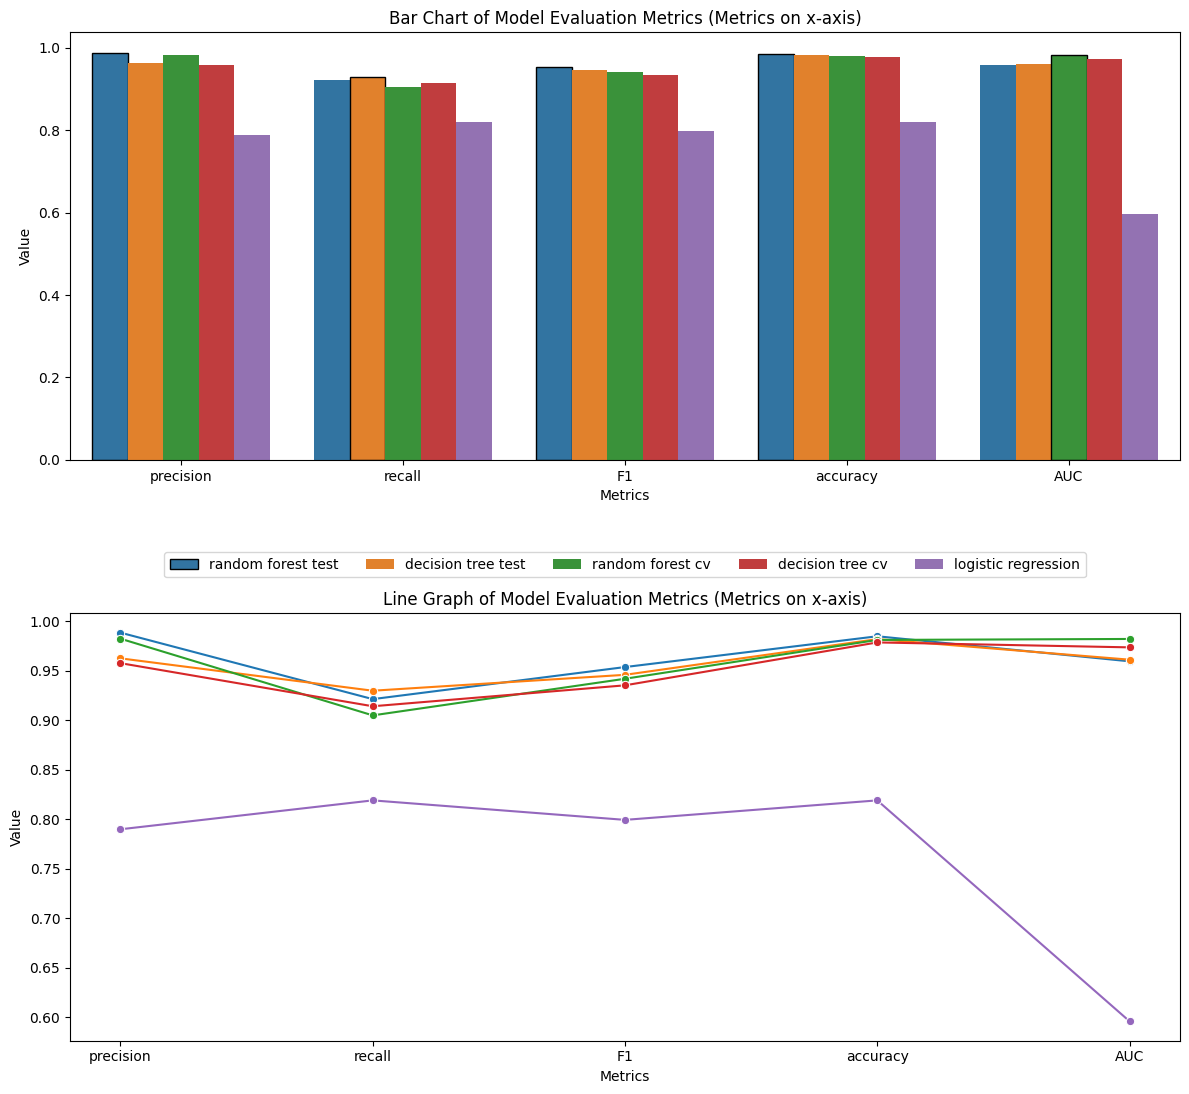

In [19]:
# Initialize the figure
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Barplot with Metrics on x-axis and new color scheme ('husl')
sns.barplot(x='metric', y='value', hue='model', data=results_long, ax=ax[0])

# Find the highest value for each metric to highlight the corresponding bar
for metric in results_long['metric'].unique():
    highest_value = results_long[results_long['metric'] == metric]['value'].max()
    # Highlight the bar with highest value for each metric
    for p in ax[0].patches:
        if p.get_height() == highest_value and p.get_x() >= list(results_long['metric'].unique()).index(metric) - 0.5:
            p.set_edgecolor('black')
            p.set_linewidth(1)

ax[0].set_title('Bar Chart of Model Evaluation Metrics (Metrics on x-axis)')
ax[0].set_ylabel('Value')
ax[0].set_xlabel('Metrics')

# Move legend to the bottom for the barplot
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)

# Line Graph with Metrics on x-axis and new color scheme ('dark')
sns.lineplot(x='metric', y='value', hue='model', data=results_long, ax=ax[1], marker='o')
ax[1].set_title('Line Graph of Model Evaluation Metrics (Metrics on x-axis)')
ax[1].set_ylabel('Value')
ax[1].set_xlabel('Metrics')

# Remove legend from the line graph
ax[1].legend_.remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Model Choices Based on Metrics:

`Random Forest Test`:Excels in Precision, F1 Score, and Accuracy. This model is less likely to falsely identify loyal employees as risks and offers an excellent general-purpose solution.

`Decision Tree Test`: Best in Recall. This model would be suitable if the company is more focused on capturing as many flight risks as possible, even at the risk of some false positives.

`Random Forest CV`:Best in AUC. This suggests that the model is excellent in differentiating between the classes. 


### Recommendation:

Given the high costs associated with false positives (misidentifying loyal employees) and false negatives (failing to identify employees who will leave), a balanced approach might be best.
`Random Forest Test` is the most balanced model, excelling in precision, F1 score, and accuracy. It's less likely to misclassify employees, enabling the HR department to take targeted actions.

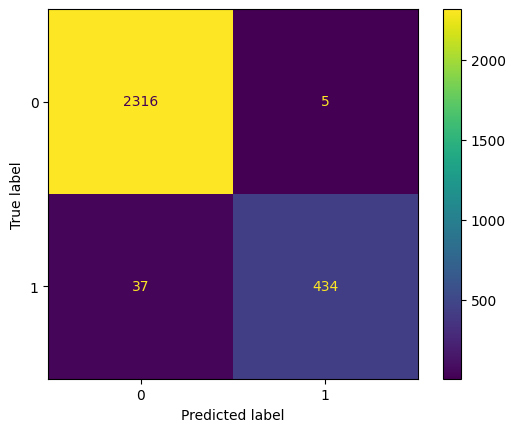

In [20]:
# Generate array of values for confusion matrix
preds = rf1.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_)
disp.plot(values_format='');

## interpretation:

* High True Negative (TN): The model correctly identified a large number of employees who are not at risk of quitting or getting fired (TN = 2316). This is a strong indicator that the model is effective at ruling out employees who are not at risk.
* High True Positive (TP): The model also correctly identified a substantial number of employees who are at risk (TP = 434). This shows that the model is also effective at flagging employees who are actually at risk.
* Low False Positive (FP): The model incorrectly flagged only a small number of employees as being at risk when they are not (FP = 37). This could lead to unnecessary interventions but is relatively low.
* Low False Negative (FN): The model missed a very low number of employees who are at risk but were classified as not being at risk (FN = 5). This is also a good sign, as missing at-risk employees could have been detrimental.

Overall, this is a robust model for identifying employees who are and are not at risk of quitting or getting fired, with a low rate of false positives and false negatives.

## Feature Importance

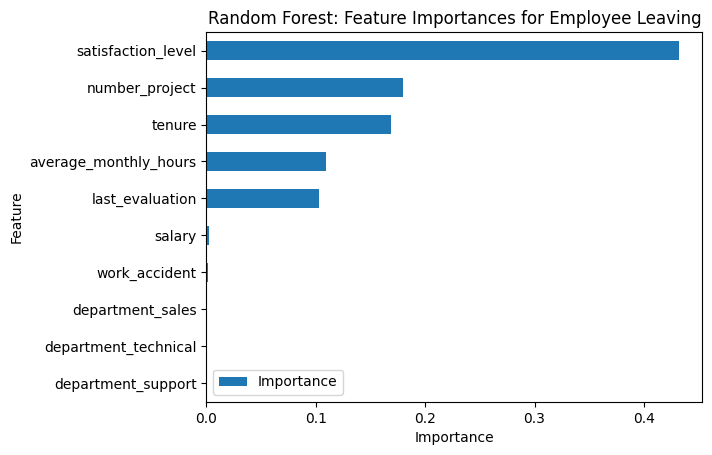

In [22]:
# Load X and y
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

# Get feature importances
feat_impt = rf1.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf1.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The features with the highest contribution in order of importance are : `satisfaction_level`, `number_project`, `tenure`, `average_monthly_hours`, `last_evaluation` and `salary`.